# KEGG enrichment of stable genes

This notebooks looks at the group of most and least stable genes and performs a KEGG enrichment analysis to determine if there are any KEGG pathways that are significantly over-represented in our most or least stable gene sets.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import json
import statsmodels.stats.multitest
from scripts import paths, utils, annotations

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Load KEGG pathway data
pao1_pathway_filename = "pao1_kegg_annot.tsv"

In [3]:
pao1_pathways = pd.read_csv(pao1_pathway_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_pathways.shape)
pao1_pathways.head()

(123, 3)


,pathway_name,num_genes,gene_ids
pathway_id_name,,,
path:pae00010 : Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis,37,"['PA3193', 'PA4732', 'PA5110', 'PA0555', 'PA47..."
path:pae00020 : Citrate cycle (TCA cycle),Citrate cycle (TCA cycle),28,"['PA1580', 'PA1562', 'PA1787', 'PA2623', 'PA26..."
path:pae00030 : Pentose phosphate pathway,Pentose phosphate pathway,28,"['PA4732', 'PA5439', 'PA3183', 'PA3182', 'PA42..."
path:pae00040 : Pentose and glucuronate interconversions,Pentose and glucuronate interconversions,8,"['PA2022', 'PA3559', 'PA2023', 'PA0607', 'PA23..."
path:pae00051 : Fructose and mannose metabolism,Fructose and mannose metabolism,19,"['PA2344', 'PA3551', 'PA2232', 'PA5452', 'PA53..."


In [6]:
# Load transcriptional similarity df
# These are the subset of genes that we will consider
pao1_similarity_scores_filename = "pao1_similarity_scores_spell.tsv"

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [7]:
pao1_similarity_scores.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA0118,PA14_01440,0.290443,1.771504e-104,NaN,NaN
PA1859,PA14_40440,0.143328,5.986934e-26,NaN,NaN
PA3190,PA14_22980,0.257508,9.170620e-82,NaN,NaN
PA1009,PA14_51280,0.549950,0.000000e+00,NaN,NaN
PA1065,PA14_50620,0.329633,9.188709e-136,NaN,NaN


In [8]:
# Get most and least stable core genes based on label
pao1_most_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "most stable"].index
)
pao1_least_stable_genes = list(
    pao1_similarity_scores[pao1_similarity_scores["label"] == "least stable"].index
)

In [9]:
# For each KEGG pathway, perform stat test, save p-values to get corrected p-values, report stats per pathway
def KEGG_enrichment_of_stable_genes(similarity_score_df, gene_list, kegg_df):
    """
    This function performs a KEGG enrichment using most or least stable genes,
    provided in `gene_list`
    """

    all_genes = set(similarity_score_df.index)
    module_genes = set(gene_list)
    not_module_genes = all_genes.difference(module_genes)

    rows = []
    # Find the KEGG pathway with significant over-representation
    for kegg_name in kegg_df.index:
        num_kegg_genes = kegg_df.loc[kegg_name, "num_genes"]
        kegg_genes = kegg_df.loc[kegg_name, "gene_ids"]
        kegg_genes = set(json.loads(kegg_genes.replace("'", '"')))

        not_kegg_genes = all_genes.difference(kegg_genes)

        # Make contingency table
        # ---------------------| most stable  | not most stable
        # in KEGG pathway      | # genes      | # genes
        # not in KEGG pathway  | # genes     | # genes
        module_kegg_genes = module_genes.intersection(kegg_genes)
        not_module_kegg_genes = not_module_genes.intersection(kegg_genes)
        module_not_kegg_genes = module_genes.intersection(not_kegg_genes)
        not_module_not_kegg_genes = not_module_genes.intersection(not_kegg_genes)

        observed_contingency_table = np.array(
            [
                [len(module_kegg_genes), len(not_module_kegg_genes)],
                [len(module_not_kegg_genes), len(not_module_not_kegg_genes)],
            ]
        )
        # Fisher's exact test
        oddsr, pval = scipy.stats.fisher_exact(
            observed_contingency_table, alternative="greater"
        )
        # chi2 test will not accept 0 counts for the contingency table
        # chi2, pval, dof, expected_counts = scipy.stats.chi2_contingency(
        #    observed_contingency_table
        # )
        # print(oddsr, pval)

        rows.append(
            {
                "enriched KEGG pathway": kegg_name,
                "odds ratio": oddsr,
                "p-value": pval,
                "num shared genes": len(module_kegg_genes),
                "size gene set": len(module_genes),
                "size KEGG pathway": num_kegg_genes,
            }
        )

    enrichment_df = pd.DataFrame(rows)

    # Get corrected pvalues
    (
        reject_,
        pvals_corrected_,
        alphacSidak,
        alphacBonf,
    ) = statsmodels.stats.multitest.multipletests(
        enrichment_df["p-value"].values,
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
    )

    enrichment_df["corrected p-value"] = pvals_corrected_
    enrichment_df["-log10 adj p-value"] = -np.log10(enrichment_df["corrected p-value"])

    return enrichment_df

In [10]:
pao1_most_stable_enrichment = KEGG_enrichment_of_stable_genes(
    pao1_similarity_scores, pao1_most_stable_genes, pao1_pathways
)

In [11]:
pao1_least_stable_enrichment = KEGG_enrichment_of_stable_genes(
    pao1_similarity_scores, pao1_least_stable_genes, pao1_pathways
)

In [12]:
print(pao1_most_stable_enrichment.shape)
pao1_most_stable_enrichment.sort_values(by="corrected p-value").head()

(123, 8)


,enriched KEGG pathway,odds ratio,p-value,num shared genes,size gene set,size KEGG pathway,corrected p-value,-log10 adj p-value
111,path:pae03010 : Ribosome,49.440021,8.053203e-38,38,267,68,9.905439e-36,35.004126
86,path:pae00970 : Aminoacyl-tRNA biosynthesis,21.576771,4.774402e-12,14,267,90,2.936257e-10,9.532206
1,path:pae00020 : Citrate cycle (TCA cycle),14.900000,2.788134e-09,12,267,28,1.143135e-07,6.941902
115,path:pae03060 : Protein export,13.655385,9.021727e-06,7,267,18,2.774181e-04,3.556865
10,path:pae00190 : Oxidative phosphorylation,5.151918,2.123878e-05,12,267,59,5.224739e-04,3.281935


In [13]:
print(pao1_least_stable_enrichment.shape)
pao1_least_stable_enrichment.sort_values(by="corrected p-value").head()

(123, 8)


,enriched KEGG pathway,odds ratio,p-value,num shared genes,size gene set,size KEGG pathway,corrected p-value,-log10 adj p-value
87,path:pae00997 : Biosynthesis of various other ...,inf,0.000006,4,267,4,0.000747,3.126455
29,path:pae00362 : Benzoate degradation,6.531008,0.000048,9,267,36,0.002961,2.528532
26,path:pae00350 : Tyrosine metabolism,6.488462,0.000342,7,267,28,0.014013,1.853475
40,path:pae00470 : D-Amino acid metabolism,6.849222,0.000718,6,267,23,0.022094,1.655731
58,path:pae00622 : Xylene degradation,9.581132,0.032585,2,267,6,0.801601,0.096042


## Plot

In [14]:
# Create a shared scale to use for both plots
# np.linspace(3.759057e-22, 1)

Text(0, 0.5, '')

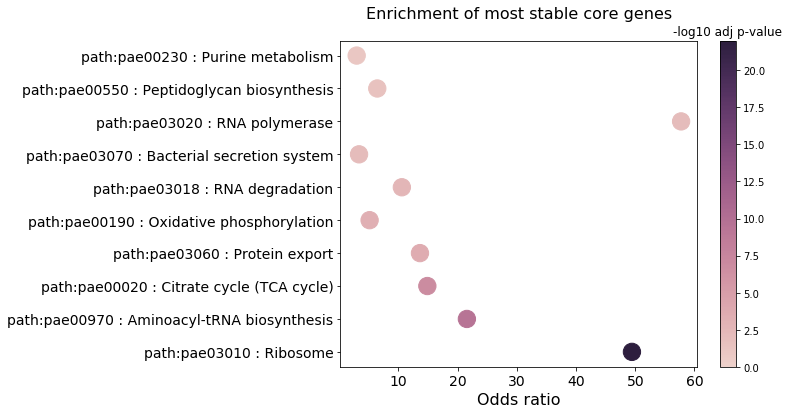

In [15]:
# Plot top most stable
pao1_most_stable_enrichment_top = pao1_most_stable_enrichment.sort_values(
    by="corrected p-value"
).head(10)
norm = plt.Normalize(0, 22)
cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(8, 6))
f = plt.scatter(
    data=pao1_most_stable_enrichment_top,
    x="odds ratio",
    y="enriched KEGG pathway",
    s=300,
    c="-log10 adj p-value",
    norm=norm,
    cmap=cmap,
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cf = plt.colorbar(sm)
cf.ax.set_title("-log10 adj p-value", fontsize=12)

plt.title("Enrichment of most stable core genes", fontsize=16, y=1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Odds ratio", fontsize=16)
plt.ylabel("")

Text(0, 0.5, '')

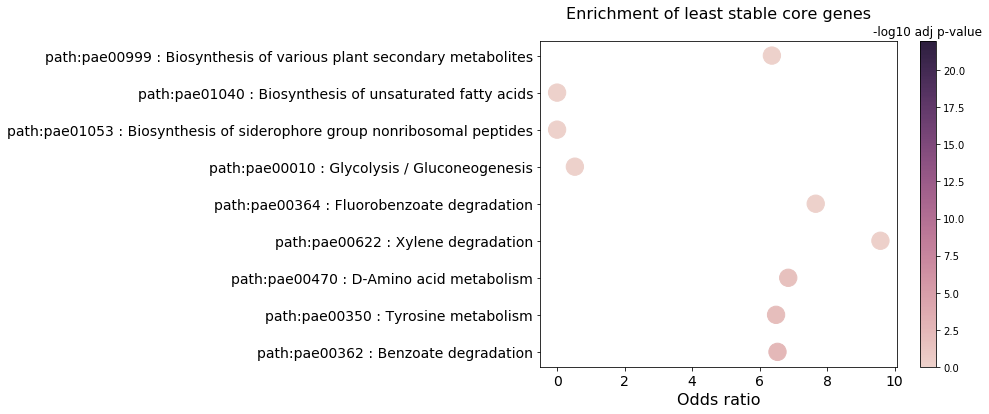

In [16]:
# Plot top most stable
pao1_least_stable_enrichment_top = pao1_least_stable_enrichment.sort_values(
    by="corrected p-value"
).head(10)
plt.figure(figsize=(8, 6))
norm = plt.Normalize(0.0, 22)
cmap = sns.cubehelix_palette(as_cmap=True)

g = plt.scatter(
    data=pao1_least_stable_enrichment_top,
    x="odds ratio",
    y="enriched KEGG pathway",
    s=300,
    c="-log10 adj p-value",
    norm=norm,
    cmap=cmap,
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cg = plt.colorbar(sm)
cg.ax.set_title("-log10 adj p-value", fontsize=12)

plt.title("Enrichment of least stable core genes", fontsize=16, y=1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Odds ratio", fontsize=16)
plt.ylabel("")

# TO DO
# Update colorbar text to include label for -log10 p-value

In [17]:
# Save
pao1_most_stable_enrichment.to_csv("pao1_most_stable_enrichment_spell.tsv", sep="\t")
pao1_least_stable_enrichment.to_csv("pao1_least_stable_enrichment_spell.tsv", sep="\t")

**Takeaway:**

KEGG enrichment analysis found that stable genes were significantly associated with essential functions: ribosome, lipopolysaccharide biosynthesis, citrate cycle. While least stable core genes are enriched in pathways related to degredation of aromatic compounds

KEGG enrichment: https://docs.google.com/spreadsheets/d/1lXZZXXjZSOuQ-cMOZ9I5llIJ2OBOQBur0Spso2WN4oY/edit#gid=0